In [88]:
import pandas as pd
import glob
from autorank import autorank
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ['DejaVu Serif', 'Bitstream Vera Serif', 'Computer Modern Roman', 'New Century Schoolbook', 'Century Schoolbook L', 'Utopia', 'ITC Bookman', 'Bookman', 'Nimbus Roman No9 L', 'Palatino', 'Charter', 'serif'],
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "legend.title_fontsize": 12,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "lines.linewidth": 2,
    "lines.markersize": 6,
    "legend.frameon": False,
    "figure.figsize": (9, 3)  # standard size for subplots
})
COLORS = ['#4c90b8', '#2ac3c1', '#f5b811', '#de653e', '#ff912a']
color_dict = {
    'BaselineAll': 'black',
    'BaselineNone': 'gray',
    'DisagreementSampling(DT)': COLORS[3],
    'DisagreementSampling(DS)': COLORS[4],
    'RandomSampling': COLORS[0],
    # add other sampling methods as needed
}
style_map = {
    'BaselineAll':    (color_dict['BaselineAll'], 'o'),
    'BaselineNone':  (color_dict['BaselineNone'], 's'),
    'DisagreementSampling(DT)':    (color_dict['DisagreementSampling(DT)'], 'o'),
    'DisagreementSampling(DS)':  (color_dict['DisagreementSampling(DS)'], '*'),
    'RandomSampling':    (color_dict['RandomSampling'], 'D'),
}

# 0. Load Result Data

In [89]:
# downstream performance and time results
dfs = []
for file_path in glob.glob('results/aggregated_results/results_downstream_*.csv'):
    dfs.append(pd.read_csv(file_path))
df_all = pd.concat(dfs, ignore_index=True)

df_all['sampling_method'] = df_all['sampling_method'].replace({
    'ConsensusSampling(DT)': 'DisagreementSampling(DT)',
    'ConsensusSampling(DS)': 'DisagreementSampling(DS)'
})

In [90]:
# invert sign for running times
df_all.loc[df_all['metric'] == 'total_time', 'value'] *= -1
df_all.loc[df_all['metric'] == 'sampling_time', 'value'] *= -1
df_all.loc[df_all['metric'] == 'model_time', 'value'] *= -1

# cleaner presentation of brackets
df_clean = df_all.copy()
bracket_cleaner = {40: '0-40', 60: '20-60', 80: '40-80', 100: '60-100', 0: 'all', np.nan: 'all'}
df_clean['bracket'] = df_clean['bracket_max'].map(bracket_cleaner)
df_clean = df_clean.drop(['bracket_min', 'bracket_max', 'mean', 'sampling_strategy', 'n_selected'], axis=1)

# joining corresponding baselines
baseline_none = df_clean[df_clean['sampling_method'] == 'BaselineNone'].drop(['bracket', 'sampling_method', 'n_sample'], axis=1).rename(columns={'value': 'baseline_none'})
baseline_all = df_clean[df_clean['sampling_method'] == 'BaselineAll'].drop(['bracket', 'sampling_method', 'n_sample'], axis=1).rename(columns={'value': 'baseline_all'})
df_clean = df_clean[~df_clean['sampling_method'].isin(['BaselineNone', 'BaselineAll'])]
join_keys = ['dataset', 'n_labeled', 'metric', 'seed', 'model']
df_clean = pd.merge(df_clean, baseline_none, on=join_keys, how='left')
df_clean = pd.merge(df_clean, baseline_all, on=join_keys, how='left')
df_clean_avg = df_clean.groupby(['model', 'dataset', 'n_labeled', 'n_sample', 'sampling_method', 'metric', 'bracket'])[['value', 'baseline_none', 'baseline_all']].mean().reset_index()

# finding the best bracket by AUPRC
df_agg = df_clean_avg[df_clean_avg['metric'] == 'auprc_macro']
idx_max_value = df_agg.groupby(['model', 'dataset', 'n_labeled', 'sampling_method', 'n_sample'])['value'].idxmax()
df_best_bracket = df_agg.loc[idx_max_value]
idx_max_value = df_agg.groupby(['model', 'dataset', 'n_labeled', 'sampling_method'])['value'].idxmax()
df_best_nsample_bracket = df_agg.loc[idx_max_value]

# 1. Time Compared to Baselines

How much faster than the baselines is sampling?

In [91]:
# Step 1: Filter to only AUPRC and total_time
df_eff = df_clean_avg[df_clean_avg['metric'].isin(['auprc_macro', 'total_time'])].copy()
# df_eff = df_eff[df_eff['sampling_method'] != 'DisagreementSampling(DS)']  ### <----- or remove DT

# Step 2: Pivot to wide format with value + baselines
df_eff = df_eff.pivot_table(
    index=['dataset', 'n_labeled', 'n_sample', 'sampling_method', 'bracket', 'model'],
    columns='metric',
    values=['value', 'baseline_all', 'baseline_none']
).reset_index()

# Flatten the multi-index columns
df_eff.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in df_eff.columns]

# Step 3: Get best row per group (highest value_auprc_macro)
df_best = df_eff.sort_values('value_auprc_macro', ascending=False).groupby(
    ['dataset', 'n_labeled', 'n_sample', 'sampling_method', 'model'], as_index=False
).first()

In [92]:
df_best['time_ratio_to_baseline_all'] = df_best['value_total_time'] / df_best['baseline_all_total_time']

In [93]:
df_time = df_best.groupby(['n_sample','sampling_method'])['time_ratio_to_baseline_all'].mean()
df_time

n_sample  sampling_method         
100       DisagreementSampling(DS)    0.149765
          DisagreementSampling(DT)    0.149791
          RandomSampling              0.150824
250       DisagreementSampling(DS)    0.177378
          DisagreementSampling(DT)    0.177057
          RandomSampling              0.177048
500       DisagreementSampling(DS)    0.219352
          DisagreementSampling(DT)    0.219298
          RandomSampling              0.218982
750       DisagreementSampling(DS)    0.264655
          DisagreementSampling(DT)    0.264537
          RandomSampling              0.265611
1000      DisagreementSampling(DS)    0.314811
          DisagreementSampling(DT)    0.314304
          RandomSampling              0.319300
Name: time_ratio_to_baseline_all, dtype: float64

In [94]:
df_time = df_best.groupby(['model', 'n_sample','sampling_method'])['time_ratio_to_baseline_all'].mean()
df_time

model   n_sample  sampling_method         
Scarf   100       DisagreementSampling(DS)    0.088324
                  DisagreementSampling(DT)    0.088557
                  RandomSampling              0.090055
        250       DisagreementSampling(DS)    0.115676
                  DisagreementSampling(DT)    0.116034
                  RandomSampling              0.117908
        500       DisagreementSampling(DS)    0.161763
                  DisagreementSampling(DT)    0.161692
                  RandomSampling              0.165312
        750       DisagreementSampling(DS)    0.206672
                  DisagreementSampling(DT)    0.206177
                  RandomSampling              0.211434
        1000      DisagreementSampling(DS)    0.248658
                  DisagreementSampling(DT)    0.246650
                  RandomSampling              0.256297
TabNet  100       DisagreementSampling(DS)    0.211206
                  DisagreementSampling(DT)    0.211025
                  Rand

In [11]:
# print(df_time.to_latex())

# 2. Time vs. AUPRC

Close look at the time/performance trade-off

In [99]:
df_tmp = df_all.copy()
bracket_cleaner = {40: '0-40', 60: '20-60', 80: '40-80', 100: '60-100', 0: 'all', np.nan: 'all'}
df_tmp['bracket'] = df_tmp['bracket_max'].map(bracket_cleaner)
df_tmp = df_tmp.drop(['bracket_min', 'bracket_max', 'mean', 'sampling_strategy', 'n_selected'], axis=1)

join_on = ['dataset', 'n_labeled', 'n_sample', 'sampling_method', 'model', 'bracket']
df_best = df_eff.sort_values('value_auprc_macro', ascending=False).groupby(
    ['dataset', 'n_labeled', 'sampling_method', 'model'], as_index=False
).first()
df_plot = pd.merge(df_best[join_on], df_tmp, on=join_on, how='left')
df_plot = pd.concat([df_plot, df_tmp[df_tmp['sampling_method'].isin(['BaselineAll', 'BaselineNone'])]])

df_plot = df_plot[df_plot['metric'].isin(['auprc_macro', 'total_time'])]
df_plot = df_plot[df_plot['n_labeled'].isin([100, 500, 1000])]
df_plot['value'] = df_plot['value'].abs()

In [100]:
df_wide = df_plot.pivot_table(
    index=['dataset', 'seed', 'n_labeled', 'n_sample', 'sampling_method', 'bracket', 'model'],
    columns='metric',
    values='value'
).reset_index()
df_wide['log_total_time'] = np.log(df_wide['total_time'])

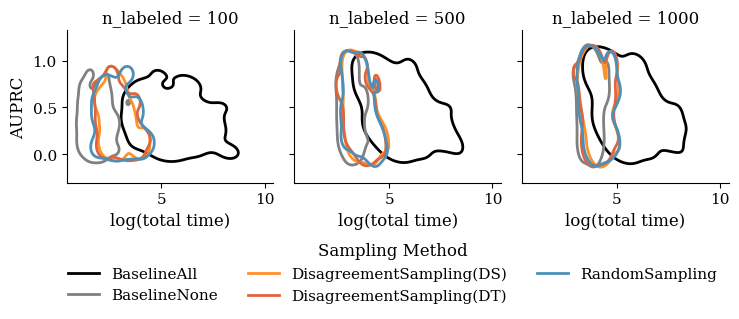

In [101]:
g = sns.FacetGrid(
    df_wide,
    col='n_labeled',
    hue='sampling_method',
    palette=color_dict,
    height=2.5,
    aspect=1,
    sharex=True,
    sharey=True,
)

g.map_dataframe(
    sns.kdeplot,
    x='log_total_time',
    y='auprc_macro',
    fill=False,
    # alpha=0.2,
    linewidth=2,
    # thresh=0.1,
    levels=[0.1]
)

# # Overlay stars at the average point for each sampling method and facet
# for (n_labeled, ax) in zip(g.col_names, g.axes.flat):
#     df_subset = df_wide[df_wide['n_labeled'] == int(n_labeled)]
#     group_means = df_subset.groupby('sampling_method')[['log_total_time', 'auprc_macro']].mean()
#     for method, row in group_means.iterrows():
#         ax.scatter(
#             row['log_total_time'],
#             row['auprc_macro'],
#             color=color_dict[method],
#             marker='*',
#             s=50,
#             zorder=3
#         )

g.set_axis_labels("log(total time)", "AUPRC")
g.set_titles("n_labeled = {col_name}")

# Create one dummy line per sampling method for the legend
handles = [
    mlines.Line2D([], [], color=color_dict[method], label=method, linewidth=2)
    for method in df_wide['sampling_method'].unique()
]

# Add manual legend below the grid
g.fig.legend(
    handles=handles,
    title="Sampling Method",
    loc="lower center",
    bbox_to_anchor=(0.53, -0.29),
    ncol=3,
    frameon=False
)

plt.subplots_adjust(bottom=0.18)
plt.tight_layout()
plt.savefig('plots/3_2_time_vs_auprc.pdf', bbox_inches='tight')
plt.show()


# 3. Time vs. n_sample

In [102]:
join_on = ['dataset', 'n_labeled', 'n_sample', 'model']
df_best_daDT = df_best[df_best['sampling_method'] == 'DisagreementSampling(DT)']
df_best_daDS = df_best[df_best['sampling_method'] == 'DisagreementSampling(DS)'][join_on + ['value_total_time']]
df_best_ra = df_best[df_best['sampling_method'] == 'RandomSampling'][join_on + ['value_total_time']]

In [103]:
df_plot = pd.merge(df_best_daDT, df_best_daDS, on=join_on, how='left')
df_plot = pd.merge(df_plot, df_best_ra, on=join_on, how='left')

In [104]:
fractions = df_best['n_sample'].unique()
competitors= ['baseline_all_total_time', 'baseline_none_total_time', 'value_total_time_x', 
              'value_total_time_y', 'value_total_time']
ranks_per_fraction = []
cds_per_fraction = []

for n_sample in fractions: 
    result = autorank(df_plot[df_plot['n_sample']==n_sample][competitors])

    # Average ranks (dict)
    avg_ranks = result.rankdf['meanrank']

    # CD value from Nemenyi post-hoc
    cd = result.cd

    # Sort ranks by method order
    ordered_ranks = [avg_ranks[method] for method in competitors]

    ranks_per_fraction.append(ordered_ranks)
    cds_per_fraction.append(cd)

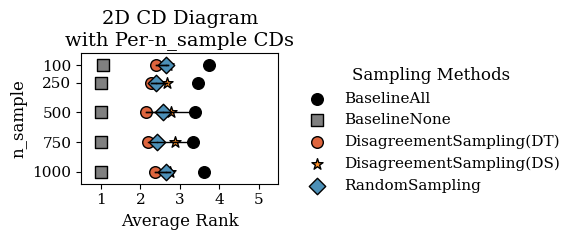

In [105]:
fig, ax = plt.subplots(figsize=(6, 2.5))

# Plot each method's average rank across fractions
for i, method in enumerate(['BaselineAll', 'BaselineNone', 'DisagreementSampling(DT)',
                            'DisagreementSampling(DS)', 'RandomSampling']):
    color, marker = style_map[method]
    ax.scatter(np.array(ranks_per_fraction)[:, i], fractions, color=color, 
               marker=marker, label=method, s=70, edgecolor='k')

# Add CD lines (Nemenyi non-significant comparisons) per row
for i, (frac, cd) in enumerate(zip(fractions, cds_per_fraction)):
    row = ranks_per_fraction[i]
    for j in range(len(competitors)):
        for k in range(j + 1, len(competitors)):
            if abs(row[j] - row[k]) <= cd:
                x1, x2 = row[j], row[k]
                ax.plot([x1, x2], [frac, frac], color='black', linewidth=1)

# Axis formatting
ax.set_ylim(0, 1100)
ax.set_xlim(0.5, len(competitors) + 0.5)
ax.set_yticks(fractions)
ax.set_xlabel("Average Rank")
ax.set_ylabel("n_sample")
ax.invert_yaxis()  # Optional: puts 1.0 on bottom
ax.set_title("2D CD Diagram\nwith Per-n_sample CDs")

# Add rank numbers at the top
ax.set_xticks(np.arange(1, len(competitors) + 1))
ax.set_xticklabels(np.arange(1, len(competitors) + 1))

# Legend
ax.legend(title="Sampling Methods", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('plots/3_3_time_vs_nsample.pdf', bbox_inches='tight')
plt.show()

# 4. Sampling time vs. Training time

In [106]:
# Step 1: Filter to only AUPRC and total_time
df_eff = df_clean_avg[df_clean_avg['metric'].isin(['sampling_time', 'model_time', 'total_time', 'auprc_macro'])].copy()

# Step 2: Pivot to wide format with value + baselines
df_eff = df_eff.pivot_table(
    index=['dataset', 'n_labeled', 'n_sample', 'sampling_method', 'bracket', 'model'],
    columns='metric',
    values=['value', 'baseline_all', 'baseline_none']
).reset_index()

# Flatten the multi-index columns
df_eff.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in df_eff.columns]

# Step 3: Get best row per group (highest value_auprc_macro)
df_best = df_eff.sort_values('value_auprc_macro', ascending=False).groupby(
    ['dataset', 'n_labeled', 'n_sample', 'sampling_method', 'model'], as_index=False
).first()

In [107]:
df_best['sampling_time_ratio'] = df_best['value_sampling_time'] / df_best['value_total_time']
df_time = df_best.groupby(['n_sample','sampling_method'])['sampling_time_ratio'].mean()
df_time

n_sample  sampling_method         
100       DisagreementSampling(DS)    0.028307
          DisagreementSampling(DT)    0.028996
          RandomSampling              0.000021
250       DisagreementSampling(DS)    0.021542
          DisagreementSampling(DT)    0.022439
          RandomSampling              0.000016
500       DisagreementSampling(DS)    0.016425
          DisagreementSampling(DT)    0.016831
          RandomSampling              0.000016
750       DisagreementSampling(DS)    0.013466
          DisagreementSampling(DT)    0.013933
          RandomSampling              0.000010
1000      DisagreementSampling(DS)    0.011484
          DisagreementSampling(DT)    0.011893
          RandomSampling              0.000008
Name: sampling_time_ratio, dtype: float64

In [108]:
df_time = df_best.groupby(['model','sampling_method'])['sampling_time_ratio'].mean()
df_time

model   sampling_method         
Scarf   DisagreementSampling(DS)    0.017451
        DisagreementSampling(DT)    0.018028
        RandomSampling              0.000012
TabNet  DisagreementSampling(DS)    0.019039
        DisagreementSampling(DT)    0.019609
        RandomSampling              0.000016
Name: sampling_time_ratio, dtype: float64

In [109]:
df_time = df_best.groupby(['sampling_method'])['sampling_time_ratio'].mean()
df_time

sampling_method
DisagreementSampling(DS)    0.018245
DisagreementSampling(DT)    0.018818
RandomSampling              0.000014
Name: sampling_time_ratio, dtype: float64

# Overall Time Consumption of our experiments

In [110]:
dfs = []
for file_path in glob.glob('results/aggregated_results/results_logs_*.csv'):
    dfs.append(pd.read_csv(file_path))
df_logs = pd.concat(dfs, ignore_index=True)


cpu_seconds = int((df_logs['user_cpu_s'] + df_logs['system_cpu_s']).sum())
wall_hours = int(df_logs['wall_time_s'].sum() / 3600)
peak_mem = int(df_logs['max_rss_mb'].max())
avg_mem = int(df_logs['max_rss_mb'].mean())

print(
    f"Our benchmark consumed a total of {cpu_seconds} CPU-seconds and ran for "
    f"{wall_hours} hours of wall-clock time across all runs, with an average memory usage of "
    f"{avg_mem} MB. These measurements reflect the aggregate compute required to evaluate "
    f"all models, sampling strategies, and dataset splits in our study."
)

Our benchmark consumed a total of 5852253 CPU-seconds and ran for 831 hours of wall-clock time across all runs, with an average memory usage of 654 MB. These measurements reflect the aggregate compute required to evaluate all models, sampling strategies, and dataset splits in our study.
